# Nuclear Mass Net

_Adapted from 2019 FRIB-TA summer school project_

In this challenge you will use the powers of __neural networks__ to learn the global trends of nuclear masses. The setup of scalers and the network are similar to the challenge for the potential energy surfaces, but our input (at first) in only the simplest possible information -- nuclear charge and mass.

In addition to plotting some predictions of the BE alone, see how well your network does on quantities like separation energies. How well do you predict the one and two neutron driplines?

One very simple thing to try (beyond just changing the architecture) is to change the target quantity when performing regression to something like BE/A instead of BE. Another interesting thing to try is to investigate feeding in additional data beyond Z and A -- perhaps the network learns the difference from the liquid drop model better than the absolute BE? Let's find out!

In [1]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
# from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

2023-06-27 15:51:03.278497: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 15:51:07.117007: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 15:51:07.118745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 15:51:19.262935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# input N,Z return model estimated binding energy
def BE(N, Z):
    # Hard code the data averages
    nucleus=xscaler.transform(np.array([[Z,N]]))
    [[BE]] = yscaler.inverse_transform(model.predict(nucleus,verbose=0))
    return BE


# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')



### Data Wrangling

First we'll read in the data and scale things to ensure they will be well behaved when the time comes to train our network

In [3]:
infile = open(data_path("MassEval2016.dat"),'r')

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.values[:],N.values[:])
xx = np.asarray(xx)
xx = xx.T
aa = np.sum(xx,axis=1)
yy = (-1.0*np.asarray(Energies)*aa).reshape(-1, 1)

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

xscaler = RobustScaler()
xscaler.fit(x_train)

xs_train = xscaler.transform(x_train)
xs_test = xscaler.transform(x_test)
xs_full = xscaler.transform(xx)

yscaler = RobustScaler()
yscaler.fit(y_train)

ys_train = yscaler.transform(y_train)
ys_test = yscaler.transform(y_test)
ys_full = yscaler.transform(yy)


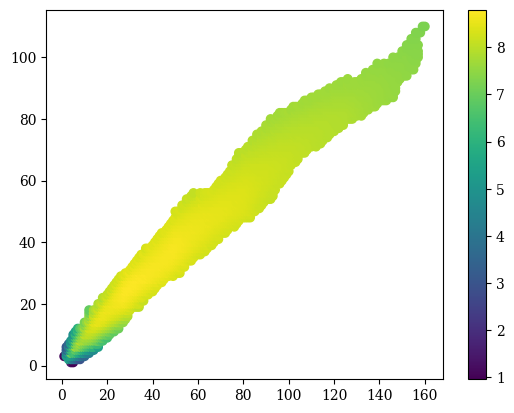

In [4]:
plt.scatter(Masses['N'],Masses['Z'],c=Masses['Ebinding'])
plt.colorbar()

### Building the Network

I've got some skeleton code for building a network using Keras but I've left the middle layers of the cake for you to bake. The syntax is verrryyyy similar, but consider trying other Keras features to improve the efficiency of your model.

In [10]:

nodes = 50
activation="relu"
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(2,),activation=activation)) #Add the input layer

model.add(tf.keras.layers.Dense(20,input_shape=(2,),activation=activation)) #Add the hidden layer
#model.add(tf.keras.layers.Dense(100)) #Add the hidden layer
#model.add() #Add the hidden layer
# do you need more hidden layers? Go for it if you want!

model.add(tf.keras.layers.Dense(1)) #Add the output layer

model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,ys_train,epochs=50, batch_size=8, validation_split=0.2,verbose=1)



Epoch 1/50
200/200 [==============================] - 2s 4ms/step - loss: 0.4100 - R2: -9390.6396 - val_loss: 0.2641 - val_R2: 0.2577
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 0.1842 - R2: -6469.9888 - val_loss: 0.0967 - val_R2: 0.7346
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0601 - R2: -2390.3984 - val_loss: 0.0263 - val_R2: 0.9287
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0158 - R2: -322.9102 - val_loss: 0.0079 - val_R2: 0.9765
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0053 - R2: -114.1754 - val_loss: 0.0034 - val_R2: 0.9882
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0028 - R2: -6.5464 - val_loss: 0.0021 - val_R2: 0.9924
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0019 - R2: -200.1898 - val_loss: 0.0014 - val_R2: 0.9951
Epoch 8/50
200/200 [==============================] - 0s 2ms/step - 

### Plotting and Performance

The following cell has an abundance of metrics being plotted and printed to judge how well we're doing with our network.

__Challenge:__ Binding energies are fine, but how do we do with separation energies? Plot those too!

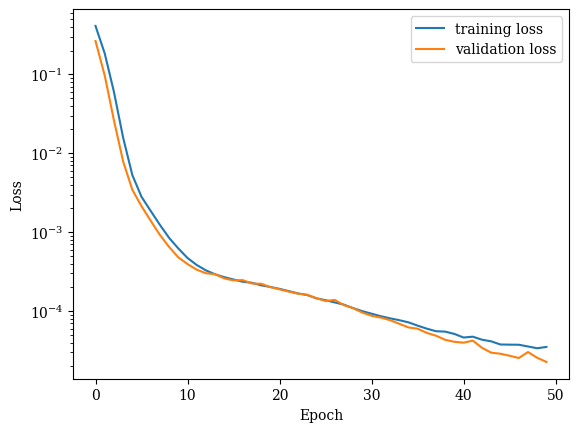

16/16 [==============================] - 0s 2ms/step - loss: 2.4346e-05 - R2: 0.9999
Test Loss: 2.435e-05
Test R2: 0.9999
78/78 [==============================] - 0s 987us/step


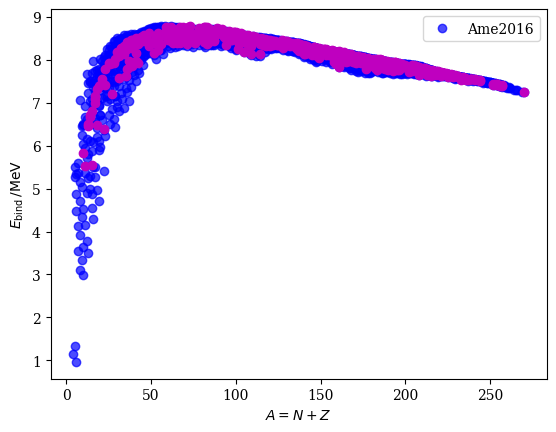

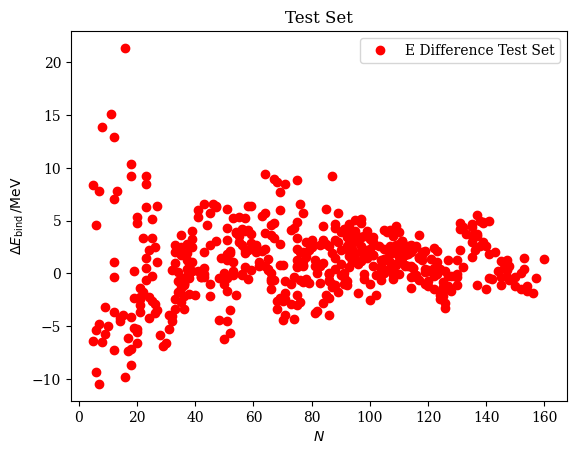

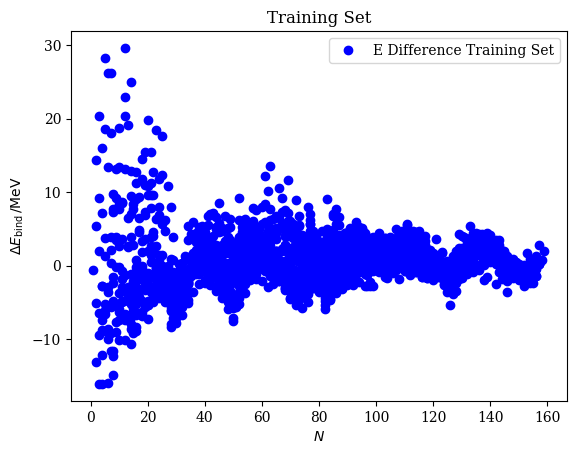

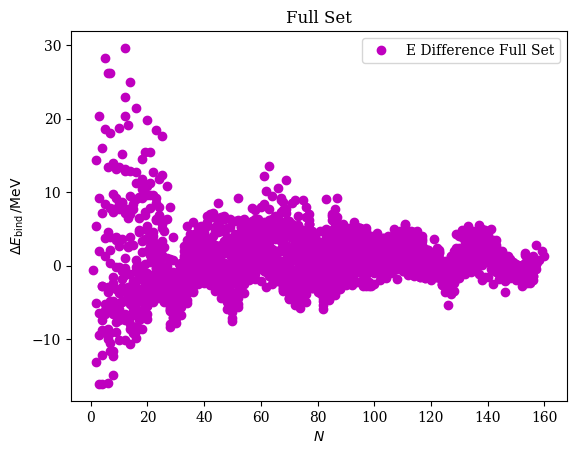

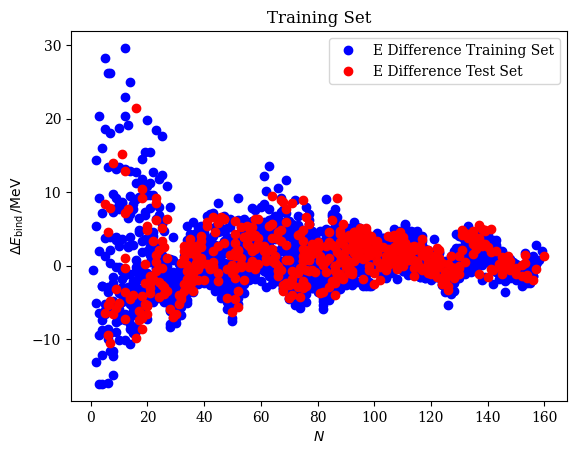

In [11]:
history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.yscale('log')
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, ys_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

testen_out=model.predict(xs_test)
trainen_out=model.predict(xs_train)
fullen_out=model.predict(xs_full)

# Shift back for plotting

x_train = xscaler.inverse_transform(xs_train)
x_test = xscaler.inverse_transform(xs_test)
x_full = xscaler.inverse_transform(xs_full)

trainen_out = yscaler.inverse_transform(trainen_out).T.squeeze()
testen_out = yscaler.inverse_transform(testen_out).T.squeeze()
fullen_out = yscaler.inverse_transform(fullen_out).T.squeeze()

a_test=np.sum(x_test,axis=1)
a_train=np.sum(x_train,axis=1)
a_full=np.sum(x_full,axis=1)

en_test=np.asarray(y_test).squeeze()
trainen_test=np.asarray(y_train).squeeze()
fullen_test=np.asarray(yy).squeeze()

diff = en_test-testen_out
traindiff = trainen_test-trainen_out
fulldiff = fullen_test-fullen_out

diff = np.asarray(diff.T).squeeze()
fulldiff = np.asarray(fulldiff.T).squeeze()
traindiff = np.asarray(traindiff.T).squeeze()

# diff = a_test*np.asarray(diff.T).squeeze()
# fulldiff = a_full*np.asarray(fulldiff.T).squeeze()
# traindiff = a_train*np.asarray(traindiff.T).squeeze()

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'o',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_test, -testen_out/a_test,'o',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')


plt.title(label="Test Set")
ax.plot(x_test[:,1], diff,'o',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')

ax.legend()
save_fig("Difference")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'o',label='E Difference Training Set',c='b')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencetrain")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_full[:,1], fulldiff,'o',label='E Difference Full Set',c='m')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Full Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencefull")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'o',label='E Difference Training Set',c='b')
ax.plot(x_test[:,1], diff,'o',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differenceboth")
plt.show()